## Doubly Latent Neural Network

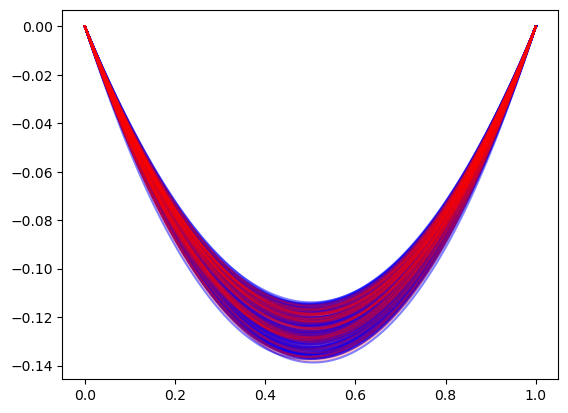

In [20]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional
import sys
import utils
import modules

# datafile = 'data/ell0.1_d15_n2048_ksigma0.316.npz'
datafile = 'data/ell2.0_d10_n100000_ksigma0.100_nx101.npz'
data = np.load(datafile)

x = torch.tensor(data['x'], dtype=torch.float32)
u_data = torch.tensor(data['u_sols'], dtype=torch.float32).T
n_total = u_data.shape[0]
n_train = 256
n_val = int(n_train * 0.3)
n_train = n_train - n_val
u_train = u_data[:n_train]
u_val = u_data[n_train:n_train+n_val]

plt.figure()
plt.plot(x, u_train.T, color='blue', alpha=0.5)
plt.plot(x, u_val.T, color='red', alpha=0.2)
None

In [21]:
class StoreState(nn.Module):
    def __init__(self, model: nn.Module, u_solve_batch: torch.Tensor):
        super(StoreState, self).__init__()
        self.model = model
        self.u_solve_batch = u_solve_batch
        with torch.no_grad():
            z = torch.randn(u_solve_batch.shape[0], self.model.latent_dim)
            self.u_solve_batch = self.model(self.u_solve_batch, z)

    def re_init(self, u_solve_batch):
        self.u_solve_batch = u_solve_batch
        with torch.no_grad():
            z = torch.randn(u_solve_batch.shape[0], self.model.latent_dim)
            self.u_solve_batch = self.model(self.u_solve_batch, z)

    def forward(self, z: torch.Tensor):
        u_solve_batch = self.model(self.u_solve_batch, z)
        self.u_solve_batch = u_solve_batch.detach()
        return u_solve_batch

torch.manual_seed(1)

n_samples = u_data.shape[0]
n_x = u_data.shape[1]
n_batch = min(100, n_samples)
u_batch = u_data[:n_batch]

latent_dim = 4
# latent_dim = 8
# hidden_features = 12
z = torch.randn(n_batch, latent_dim)

omega_0 = 1.0
in_features = 4 + latent_dim
hidden_features = 10
hidden_layers = 2
out_features = 1

beta = 1e-2

def get_N():
    return modules.Siren(in_features=in_features, hidden_features=hidden_features, hidden_layers=hidden_layers,
                         out_features=out_features, outermost_linear=True, first_omega_0=omega_0,
                         hidden_omega_0=omega_0)

decoder_extra_args = modules.SolutionOfPDENet(get_N, x, latent_dim, init_kwaargs={'max_iter': 5, 'n_batch': 200})
u_solve_batch = torch.zeros(n_batch, n_x-2)
decoder = StoreState(decoder_extra_args, u_solve_batch)

encoder = modules.Siren(in_features=n_x-2, hidden_features=hidden_features, hidden_layers=hidden_layers,
                            out_features=latent_dim, outermost_linear=True, first_omega_0=omega_0,
                            hidden_omega_0=omega_0)

vae = modules.VAE(encoder, decoder, latent_dim)

Text(0.5, 1.0, 'Initial States')

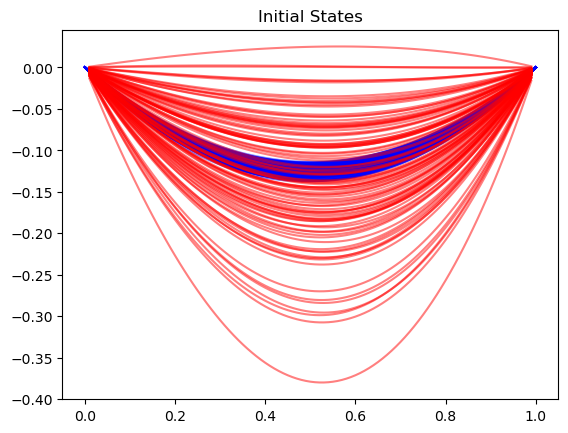

In [22]:
z = torch.randn(n_batch, latent_dim)
u_solve_batch = vae.decoder(z)

plt.figure()
plt.plot(x, u_batch.T, color='blue', alpha=0.5)
plt.plot(x[1:-1], u_solve_batch.T.detach(), color='red', alpha=0.5)
plt.title('Initial States')

In [23]:
# Train the vae
epochs = 2000
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)
train_losses = np.zeros((epochs, 3))

for epoch in range(epochs):
    optimizer.zero_grad()
    loss, recon_loss, kl_loss = vae.loss_fn(u_batch[:, 1:-1], beta=beta)
    loss.backward()
    optimizer.step()
    train_losses[epoch] = [loss.item(), recon_loss.item(), kl_loss.item()]

    # nan
    if torch.isnan(loss):
        print('NaN loss, breaking')
        break

    if epochs < 25 or epoch % (epochs // 25) == 0 or epoch == epochs - 1:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4e}, Recon Loss: {recon_loss.item():.4e}, KL Loss: {kl_loss.item():.4e}')

plt.figure()
plt.semilogy(train_losses)
plt.legend(['Total', 'Reconstruction', 'KL Divergence'])

Epoch 1/2000, Loss: 6.7645e-03, Recon Loss: 2.1092e-03, KL Loss: 4.6553e-01
Epoch 81/2000, Loss: 3.1084e-03, Recon Loss: 4.1783e-04, KL Loss: 2.6906e-01
Epoch 161/2000, Loss: 1.9341e-03, Recon Loss: 9.9078e-05, KL Loss: 1.8350e-01
Epoch 241/2000, Loss: 1.3209e-03, Recon Loss: 5.7515e-05, KL Loss: 1.2634e-01
Epoch 321/2000, Loss: 9.3605e-04, Recon Loss: 4.9774e-05, KL Loss: 8.8627e-02
Epoch 401/2000, Loss: 6.8085e-04, Recon Loss: 4.0988e-05, KL Loss: 6.3986e-02
Epoch 481/2000, Loss: 5.2685e-04, Recon Loss: 5.8527e-05, KL Loss: 4.6832e-02
Epoch 561/2000, Loss: 3.7540e-04, Recon Loss: 3.4486e-05, KL Loss: 3.4091e-02
Epoch 641/2000, Loss: 2.7273e-04, Recon Loss: 2.8936e-05, KL Loss: 2.4379e-02
Epoch 721/2000, Loss: 2.0267e-04, Recon Loss: 3.2671e-05, KL Loss: 1.7000e-02
Epoch 801/2000, Loss: 1.4328e-04, Recon Loss: 2.8092e-05, KL Loss: 1.1518e-02
Epoch 881/2000, Loss: 1.1034e-04, Recon Loss: 3.4533e-05, KL Loss: 7.5811e-03
Epoch 961/2000, Loss: 7.6010e-05, Recon Loss: 2.7410e-05, KL Loss: 

KeyboardInterrupt: 

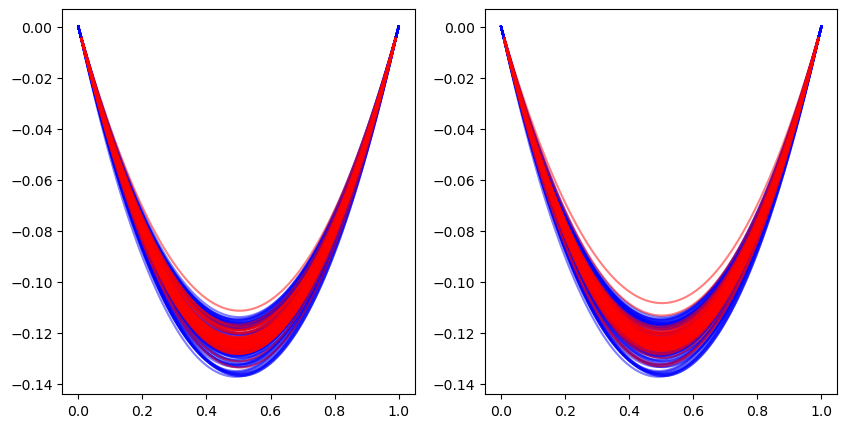

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x, u_batch.T, color='blue', alpha=0.50)
ax[0].plot(x[1:-1], u_solve_batch.T.detach(), color='red', alpha=0.5)

vae.eval()
n_samples = 100
z = torch.randn(n_samples, latent_dim)
u_samples = torch.zeros(n_samples, n_x-2)
vae.decoder.u_solve_batch = u_samples
u_samples = vae.decode(z)

ax[1].plot(x, u_batch.T, color='blue', alpha=0.5)
ax[1].plot(x[1:-1], u_samples.T.detach(), color='red', alpha=0.5)


torch.Size([100, 99])
torch.Size([100, 101])


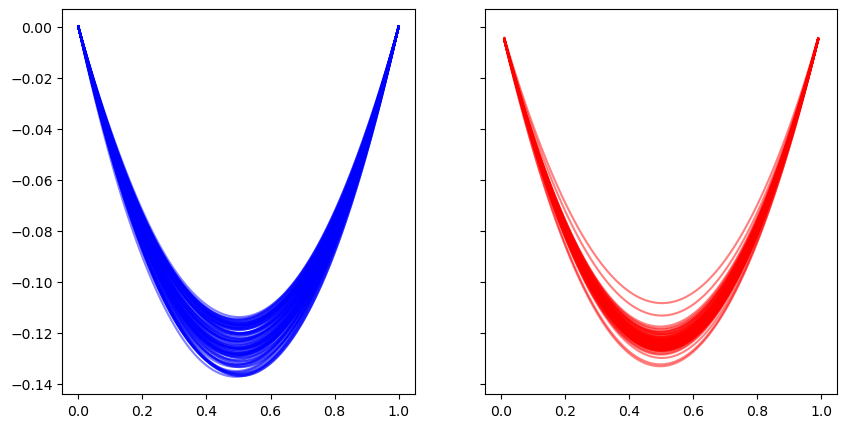

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].plot(x, u_batch.T, color='blue', alpha=0.5)
ax[1].plot(x[1:-1], u_samples.T.detach(), color='red', alpha=0.5)

print(u_samples.shape)
print(u_batch.shape)

torch.Size([100, 99])
torch.Size([100, 101])


Text(0.5, 1.0, 'Sampled: Mean -1.2406e-01, Var 1.0496e-05\nActual: Mean -1.2474e-01, Var 4.2832e-05')

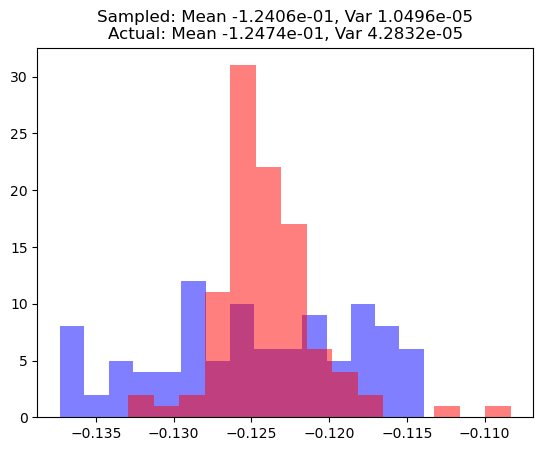

In [29]:
print(u_samples.shape)
print(u_batch.shape)

cmp_ind_batch = u_batch.shape[1]//2
cmp_ind_samples = cmp_ind_batch + 1

# compute actual mean and variance
u_cmp_batch = u_batch[:, cmp_ind_batch]
u_cmp_samples = u_samples[:, cmp_ind_samples]
mean_batch = u_cmp_batch.mean().item()
mean_samples = u_cmp_samples.mean().item()
var_batch = u_cmp_batch.var().item()
var_samples = u_cmp_samples.var().item()

# compare histogram at index
plt.figure()
plt.hist(u_cmp_batch, bins=15, alpha=0.5, color='blue')
with torch.no_grad():
    plt.hist(u_cmp_samples, bins=15, alpha=0.5, color='red')
plt.title(f'Sampled: Mean {mean_samples:.4e}, Var {var_samples:.4e}\nActual: Mean {mean_batch:.4e}, Var {var_batch:.4e}')